In [1]:
import torch
import torch.distributions as dist
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [62]:
batch_size = 512
dl_train = torch.utils.data.DataLoader(
    datasets.FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True),
batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(
    datasets.FashionMNIST('.', train=False, transform=transforms.ToTensor(), download=True),
batch_size=batch_size * 3, shuffle=False)

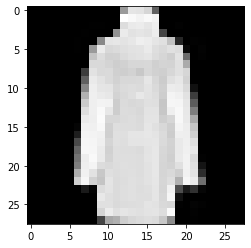

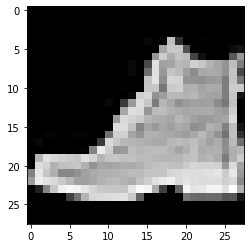

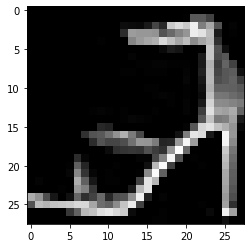

In [63]:
batch, _ = next(iter(dl_train))

for i in range(3):
    plt.imshow(1 - batch[i].view(28, 28).numpy(), cmap='Greys')
    plt.show()
    
del batch

In [64]:
def middle_size(size_in, size_out):
    """
    Make a funnel with regard to the number of weights.
    """
    return (size_in - size_out) // 2 + size_out

class VAE(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.latent_size = latent_size 
        size = middle_size(784, self.latent_size)
        
        # Encode into gaussian paramaters. First part of vector is mu and second part log variance
        self.encoder = nn.Sequential(
            nn.Linear(784, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, latent_size * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, size),
            nn.ReLU(),
            nn.Linear(size, 784),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)  # unit gaussian
        z = mu + eps * std 
        return z

    def forward(self, x):
        z_theta = self.encoder(x)
        mu = z_theta[:, :self.latent_size]
        log_var = z_theta[:, self.latent_size:]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var, z

In [73]:
def loss_function(reconstruction_x, x, mu, log_var, z, mc_kl=True, beta=1.):
    likelihood = F.binary_cross_entropy(reconstruction_x, x.view(-1, 784), reduction='sum')
    
    # is worse then the analyitical solution, but is better for comparing ELBO with Flows
    if mc_kl:
        log_prior = dist.Normal(0, 1).log_prob(z)
        log_p_q = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z)
        kl = (log_p_q - log_prior).sum()
    else: 
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

    return (likelihood + beta * kl) / x.shape[0]

In [74]:
def evaluate_test(device='cuda'):
    avg_loss = 0
    with torch.no_grad():
        for (x, _) in dl_test:
            x = x.to(device).view(-1, 784)
            reconstruction_x, mu, log_var, z = m(x)
            avg_loss += loss_function(reconstruction_x, x, mu, log_var, z, 1)
    return (avg_loss / len(dl_test.dataset)).item()
  
m = VAE(latent_size)
m.cuda()
evaluate_test()

0.3865041732788086

In [75]:
latent_size = 32
m = VAE(latent_size)
m.cuda()

vae_loss = []

def log_training(batch_idx, x, loss):
    if batch_idx % 400 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(x), len(dl.dataset),
            100. * batch_idx / len(dl),
            loss.item() / len(x)))

def train(epoch, m, device, optimizer, beta):
    m.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(dl_train):
        x = x.to(device).view(-1, 784)
        
        optim.zero_grad()
        reconstruction_x, mu, log_var, z = m(x)
        loss = loss_function(reconstruction_x, x, mu, log_var, z, beta)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(dl_train.dataset)
    print('Epoch: {:3d}'
          '\tAverage loss: {:.4f}'
          '\tAverage test loss: {:.4f}'
          '\tBeta: {:.3f}'.format(epoch, avg_loss, evaluate_test(), beta))
    vae_loss.append(avg_loss)


# optim = torch.optim.Adam(m.parameters(), 5e-4)

# for epoch in range(1, 111):
#     beta = min(1, 1 / 90 * epoch)
#     train(epoch, m, 'cuda', optim, beta)
    
optim = torch.optim.Adam(m.parameters(), 1e-2)

for epoch in range(1, 50):
    beta = 1.
    train(epoch, m, 'cuda', optim, beta)

Epoch:   1	Average loss: 0.6467	Average test loss: 0.2048	Beta: 1.000
Epoch:   2	Average loss: 0.5570	Average test loss: 0.1945	Beta: 1.000
Epoch:   3	Average loss: 0.5292	Average test loss: 0.1865	Beta: 1.000
Epoch:   4	Average loss: 0.5123	Average test loss: 0.1829	Beta: 1.000
Epoch:   5	Average loss: 0.5071	Average test loss: 0.1807	Beta: 1.000
Epoch:   6	Average loss: 0.5020	Average test loss: 0.1797	Beta: 1.000
Epoch:   7	Average loss: 0.4995	Average test loss: 0.1791	Beta: 1.000
Epoch:   8	Average loss: 0.4980	Average test loss: 0.1784	Beta: 1.000
Epoch:   9	Average loss: 0.4963	Average test loss: 0.1785	Beta: 1.000
Epoch:  10	Average loss: 0.4959	Average test loss: 0.1778	Beta: 1.000
Epoch:  11	Average loss: 0.4949	Average test loss: 0.1776	Beta: 1.000
Epoch:  12	Average loss: 0.4937	Average test loss: 0.1780	Beta: 1.000
Epoch:  13	Average loss: 0.4939	Average test loss: 0.1784	Beta: 1.000
Epoch:  14	Average loss: 0.4935	Average test loss: 0.1787	Beta: 1.000
Epoch:  15	Average l

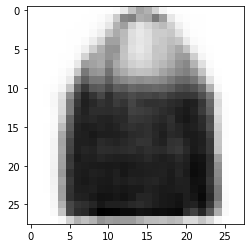

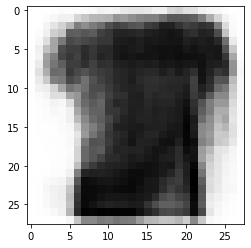

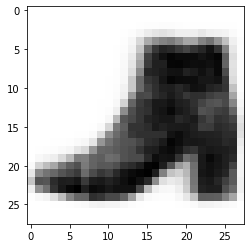

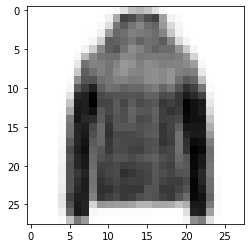

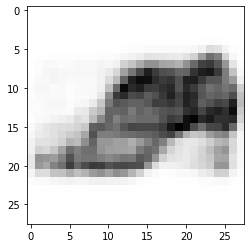

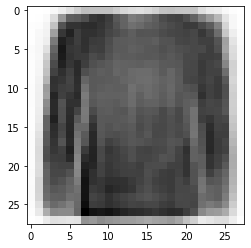

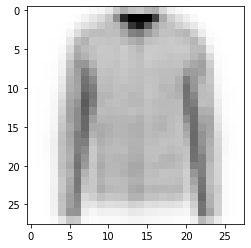

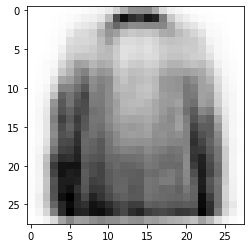

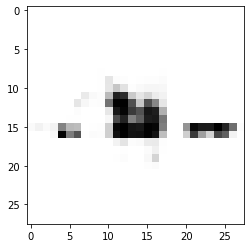

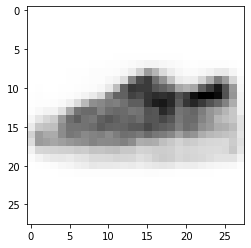

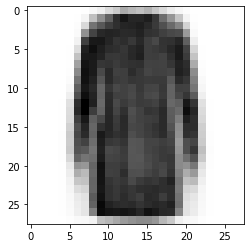

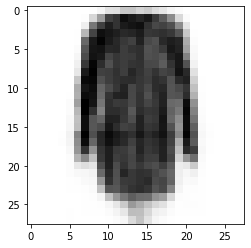

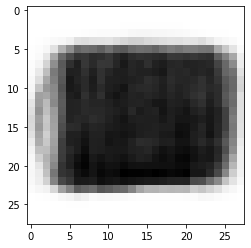

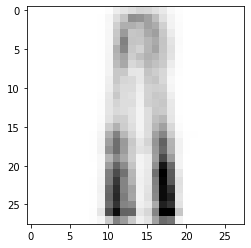

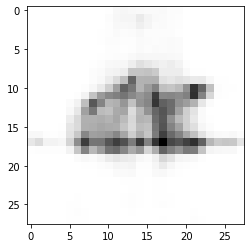

In [76]:
def show_samples(m, n=15, device='cuda'):
    with torch.no_grad():
        # take n samples
        sample = torch.randn(n, latent_size).to(device)
        sample = m.decoder(sample).cpu().view(-1, 28, 28)
        
    for i in range(sample.shape[0]):
        plt.imshow(sample[i].view(28, 28), cmap='Greys')
        plt.show()
        
show_samples(m)

# Basic planar flow

In [67]:
class PlanarFlow(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        """
        shape u = (batch_size, z_size, 1)
        shape w = (batch_size, 1, z_size)
        shape b = (batch_size, 1, 1)
        shape z = (batch_size, z_size).
        """
        super().__init__()
        self.u = nn.Parameter(torch.randn(size, 1).normal_(0, 0.01))
        self.w = nn.Parameter(torch.randn(1, size).normal_(0, 0.01))
        self.b = nn.Parameter(torch.zeros(1))
    
    @property
    def normalized_u(self):
        """
        Needed for invertibility condition.
        
        See Appendix A.1
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        # softplus
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))
        wtu = self.w @ self.u
        w_div_w2 = self.w.t() / torch.sum(self.w ** 2, dim=1, keepdim=True)
        return self.u + (m(wtu) - wtu) * w_div_w2
    
    def psi(self, z):
        """
        ψ(z) =h′(w^tz+b)w
        
        See eq(11)
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        return self.h_prime(z @ self.w.t() + self.b) @ self.w
    
    def h(self, x):
        return torch.tanh(x)
        
    def h_prime(self, z):
        return 1 - torch.tanh(z)**2
        
    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_ldj = z
        else:
            z, accumulating_ldj = z, 0
        psi = self.psi(z)

        u = self.normalized_u

        # determinant of jacobian
        det = (1 + psi @ u)

        # log |det Jac|
        ldj = torch.log(torch.abs(det) + 1e-6)
        
        wzb = z @ self.w.t() + self.b
 
        fz = z + (u.t() * self.h(wzb))

        return fz, ldj + accumulating_ldj



class FlowVAE(VAE):
    def __init__(self, latent_size, n_flows=20):
        super().__init__(latent_size)
                
        self.flow = nn.Sequential(*[
            PlanarFlow(latent_size) for _ in range(n_flows)
        ])   
            
    def forward(self, x):
        z_theta = self.encoder(x)
        mu0 = z_theta[:, :self.latent_size]
        log_var0 = z_theta[:, self.latent_size:]
        z0 = self.reparameterize(mu0, log_var0)
        zk, accumulating_ldj = self.flow(z0)
        
        return z0, zk, self.decoder(zk), accumulating_ldj, mu0, log_var0
    

In [96]:

def det_loss(reconstruction_x, x, mu, log_var, z_0, z_k, ldj, beta=1.):
    """
    :param z_mu: mean of z_0
    :param z_var: variance of z_0
    :param z_0: first stochastic latent variable
    :param z_k: last stochastic latent variable
    :param ldj: log det jacobian
    """

    batch_size = x.size(0)

    # - N E_q0 [ ln p(x|z_k) ]
    likelihood = F.binary_cross_entropy(reconstruction_x, x, reduction='sum')

    # ln p(z_k)  (not averaged)
    log_p_zk = dist.Normal(0, 1).log_prob(z_k)
    # ln q(z_0)  (not averaged)
    log_q_z0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    
    return (log_q_z0.sum() + beta * (likelihood - log_p_zk.sum()) - ldj.sum()) / batch_size
    
#     # N E_q0[ ln q(z_0) - ln p(z_k) ]
#     summed_logs = torch.sum(log_q_z0 - log_p_zk)

#     # sum over batches
#     summed_ldj = torch.sum(ldj)

#     # ldj = N E_q_z0[\sum_k log |det dz_k/dz_k-1| ]
#     kl = (summed_logs - summed_ldj)
#     loss = likelihood + beta * kl

#     return loss / x.shape[0]

def evaluate_test(device='cuda'):
    avg_loss = 0
    with torch.no_grad():
        for (x, _) in dl_test:
            x = x.to(device).view(-1, 784)
            z0, zk, reconstruction_x, ldj, mu0, log_var0 = m(x)

            avg_loss += det_loss(x=x, 
                            reconstruction_x=reconstruction_x, 
                            mu=mu0,
                            log_var=log_var0,
                            ldj=ldj,
                            z_0=z0,
                            z_k=zk,
                            beta=beta
                            )
    return (avg_loss / len(dl_test.dataset)).item()
  

In [69]:
m = FlowVAE(latent_size, n_flows=32)
m.cuda()

flow_loss = []

def train(epoch, m, device, optimizer, beta):
    m.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(dl_train):
        x = x.to(device).view(-1, 784)
        
        optim.zero_grad()
        z0, zk, reconstruction_x, ldj, mu0, log_var0 = m(x)
    
        loss = det_loss(x=x, 
                        reconstruction_x=reconstruction_x, 
                        mu=mu0,
                        log_var=log_var0,
                        ldj=ldj,
                        z_0=z0,
                        z_k=zk,
                        beta=beta
                        )
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(dl_train.dataset)
    print('Epoch: {:3d}'
          '\tAverage loss: {:.4f}'
          '\tAverage test loss: {:.4f}'
          '\tBeta: {:.3f}'.format(epoch, avg_loss, evaluate_test(), beta))
    vae_loss.append(avg_loss)


optim = torch.optim.Adam(m.parameters(), 1e-2)

for epoch in range(1, 50):
#     beta = min(1, 1 / 90 * epoch)
    beta = 1.
    train(epoch, m, 'cuda', optim, beta)

Epoch:   1	Average loss: 3.0833	Average test loss: 0.1994	Beta: 1.000
Epoch:   2	Average loss: 0.5354	Average test loss: 0.1869	Beta: 1.000
Epoch:   3	Average loss: 0.5139	Average test loss: 0.1829	Beta: 1.000
Epoch:   4	Average loss: 0.5071	Average test loss: 0.1813	Beta: 1.000
Epoch:   5	Average loss: 0.5028	Average test loss: 0.1803	Beta: 1.000
Epoch:   6	Average loss: 0.5001	Average test loss: 0.1792	Beta: 1.000
Epoch:   7	Average loss: 0.4980	Average test loss: 0.1787	Beta: 1.000
Epoch:   8	Average loss: 0.4967	Average test loss: 0.1783	Beta: 1.000
Epoch:   9	Average loss: 0.4948	Average test loss: 0.1781	Beta: 1.000
Epoch:  10	Average loss: 0.4949	Average test loss: 0.1773	Beta: 1.000
Epoch:  11	Average loss: 0.4922	Average test loss: 0.1765	Beta: 1.000
Epoch:  12	Average loss: 0.4918	Average test loss: 0.1761	Beta: 1.000
Epoch:  13	Average loss: 0.4906	Average test loss: 0.1764	Beta: 1.000
Epoch:  14	Average loss: 0.4902	Average test loss: 0.1762	Beta: 1.000
Epoch:  15	Average l

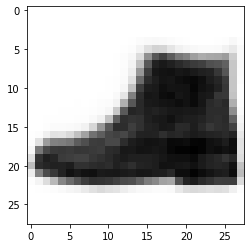

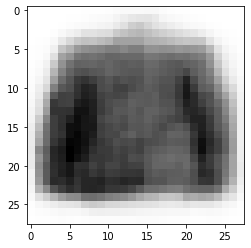

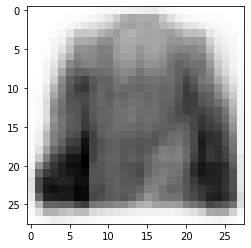

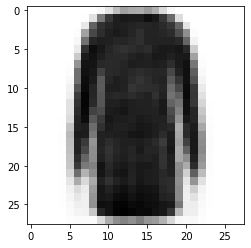

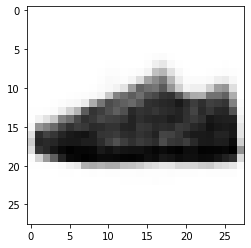

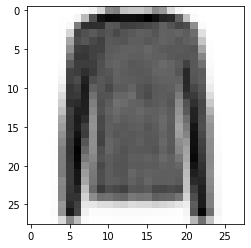

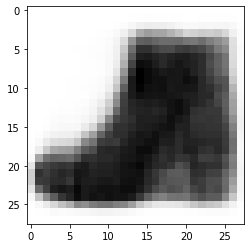

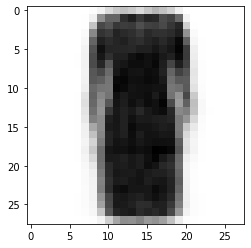

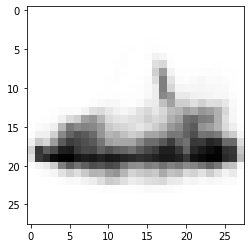

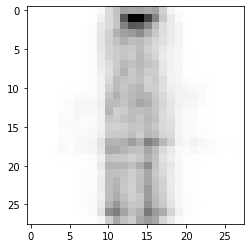

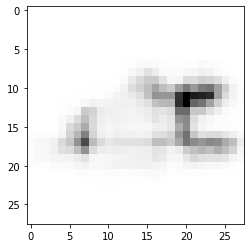

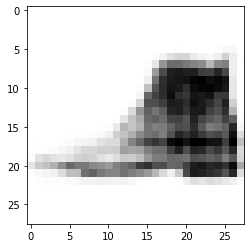

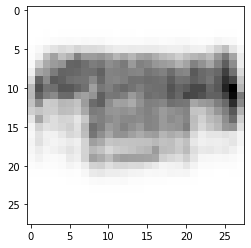

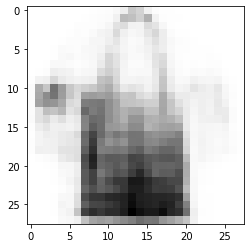

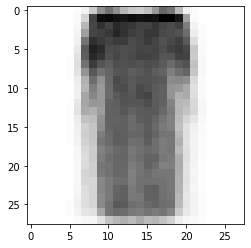

In [71]:
show_samples(m)

In [82]:
from PIL import Image
import numpy as np

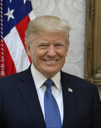

In [83]:
img = Image.open('/home/ritchie46/Downloads/Donald_Trump_official_portrait.jpg')
img.thumbnail((128, 128))
img

In [84]:
img = img.convert('1')


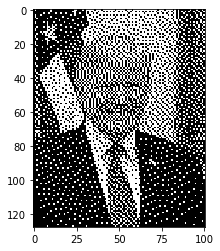

In [85]:
img = 1 - np.array(img)
plt.imshow(img, cmap="Greys")

In [86]:
img.shape
img = torch.tensor(img, dtype=torch.float)

In [87]:
def show_z(z):
    a = z.numpy().reshape(img.shape)
    plt.imshow(a, cmap="Greys")
    plt.show()
    
size = img.shape[0] * img.shape[1]

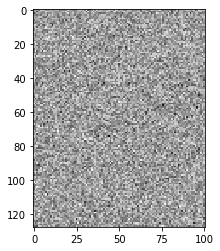

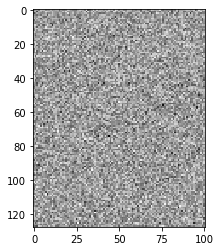

In [89]:
class Flow(nn.Module):
    def __init__(self, n_flows=10):
        super().__init__()
        self.flow =  nn.Sequential(*[
            PlanarFlow(size) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.randn(size,).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(size,).normal_(0, 0.01))
        
    def forward(self):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn_like(std)  # unit gaussian
        z0 = self.mu + eps * std 
        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var
        

flow = Flow()
z0, zk, ldj, mu, log_var = flow()

show_z(z0.data)
show_z(zk.data)

In [90]:
flow = Flow()

def train_flow(flow, epochs=250):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-3)
    for _ in range(epochs):

        z0, zk, ldj, mu, log_var = flow()

        loss = det_loss(reconstruction_x=torch.sigmoid(zk),
                       x=img,
                       mu=mu,
                       log_var=log_var,
                       z_0=z0,
                       z_k=zk,
                       ldj=ldj)
        loss.backward()
        optim.step()
        optim.zero_grad()  

    

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([128, 101])) that is different to the input size (torch.Size([1, 12928])) is deprecated. Please ensure they have the same size.
  del sys.path[0]


N flows: 5


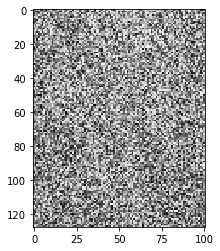

N flows: 20


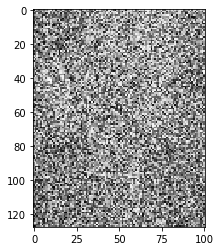

N flows: 32


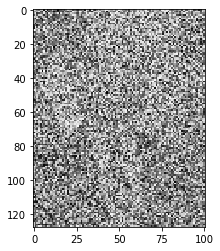

N flows: 64


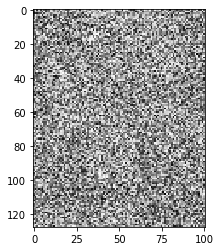

In [93]:
for n in [5, 20, 32, 64]:
    flow = Flow(n)
    train_flow(flow)
    z0, zk, ldj, mu, log_var = flow()
    print('N flows:', n)
    show_z(torch.sigmoid(zk).data)

# Amortized planar flow

In [98]:
# https://github.com/riannevdberg/sylvester-flows

class Planar(nn.Module):
    """
    PyTorch implementation of planar flows as presented in "Variational Inference with Normalizing Flows"
    by Danilo Jimenez Rezende, Shakir Mohamed. Model assumes amortized flow parameters.
    """

    def __init__(self):

        super(Planar, self).__init__()

        self.h = nn.Tanh()
        self.softplus = nn.Softplus()

    def der_h(self, x):
        """ Derivative of tanh """

        return 1 - self.h(x) ** 2

    def forward(self, zk, u, w, b):
        """
        Forward pass. Assumes amortized u, w and b. Conditions on diagonals of u and w for invertibility
        will be be satisfied inside this function. Computes the following transformation:
        z' = z + u h( w^T z + b)
        or actually
        z'^T = z^T + h(z^T w + b)u^T
        Assumes the following input shapes:
        shape u = (batch_size, z_size, 1)
        shape w = (batch_size, 1, z_size)
        shape b = (batch_size, 1, 1)
        shape z = (batch_size, z_size).
        """

        zk = zk.unsqueeze(2)

        # reparameterize u such that the flow becomes invertible (see appendix paper)
        uw = torch.bmm(w, u)
        m_uw = -1. + self.softplus(uw)
        w_norm_sq = torch.sum(w ** 2, dim=2, keepdim=True)
        u_hat = u + ((m_uw - uw) * w.transpose(2, 1) / w_norm_sq)

        # compute flow with u_hat
        wzb = torch.bmm(w, zk) + b
        z = zk + u_hat * self.h(wzb)
        z = z.squeeze(2)

        # compute logdetJ
        psi = w * self.der_h(wzb)
        log_det_jacobian = torch.log(torch.abs(1 + torch.bmm(psi, u_hat)))
        log_det_jacobian = log_det_jacobian.squeeze(2).squeeze(1)

        return z, log_det_jacobian

class PlanarVAE(VAE):
    """
    Variational auto-encoder with planar flows in the encoder.
    """
    def __init__(self, latent_size, n_flows):
        super(PlanarVAE, self).__init__(latent_size)

        # Initialize log-det-jacobian to zero
        self.log_det_j = 0.

        # Flow parameters
        flow = Planar
        self.n_flows = n_flows

        # Amortized flow parameters
        self.amor_u = nn.Linear(latent_size * 2, n_flows * latent_size)
        self.amor_w = nn.Linear(latent_size * 2, n_flows * latent_size)
        self.amor_b = nn.Linear(latent_size * 2, n_flows)

        # Normalizing flow layers
        for k in range(n_flows):
            flow_k = flow()
            self.add_module('flow_' + str(k), flow_k)

    def encode(self, x):
        """
        Encoder that ouputs parameters for base distribution of z and flow parameters.
        """

        batch_size = x.size(0)

        h = self.q_z_nn(x)
        h = h.view(-1, self.q_z_nn_output_dim)
        mean_z = self.q_z_mean(h)
        var_z = self.q_z_var(h)

        # return amortized u an w for all flows
        u = self.amor_u(h).view(batch_size, self.num_flows, self.z_size, 1)
        w = self.amor_w(h).view(batch_size, self.num_flows, 1, self.z_size)
        b = self.amor_b(h).view(batch_size, self.num_flows, 1, 1)

        return mean_z, var_z, u, w, b

    def forward(self, x):
        """
        Forward pass with planar flows for the transformation z_0 -> z_1 -> ... -> z_k.
        Log determinant is computed as log_det_j = N E_q_z0[\sum_k log |det dz_k/dz_k-1| ].
        """
        batch_size = x.shape[0]
        z_theta = self.encoder(x)
        mu0 = z_theta[:, :self.latent_size]
        log_var0 = z_theta[:, self.latent_size:]
        
        u = self.amor_u(z_theta).view(batch_size, self.n_flows, self.latent_size, 1)
        w = self.amor_w(z_theta).view(batch_size, self.n_flows, 1, self.latent_size)
        b = self.amor_b(z_theta).view(batch_size, self.n_flows, 1, 1)
            
        self.log_det_j = 0.
        z = [self.reparameterize(mu0, log_var0)]
        
        # Normalizing flows
        for k in range(self.n_flows):
            flow_k = getattr(self, 'flow_' + str(k))
            z_k, log_det_jacobian = flow_k(z[k], u[:, k, :, :], w[:, k, :, :], b[:, k, :, :])
            z.append(z_k)
            self.log_det_j += log_det_jacobian
            
        z0 = z[0]
        zk = z[-1]
        
        return z0, zk, self.decoder(zk), self.log_det_j, mu0, log_var0

m = PlanarVAE(20, 10)
m(next(iter(dl_train))[0].view(-1, 784));

In [99]:
m = PlanarVAE(latent_size, 16)
m.cuda()
optim = torch.optim.Adam(m.parameters(), 1e-2)

for epoch in range(1, 50):
    beta = 1.
    train(epoch, m, 'cuda', optim, beta)

Epoch:   1	Average loss: 0.8979	Average test loss: 0.2050	Beta: 1.000
Epoch:   2	Average loss: 0.5478	Average test loss: 0.1903	Beta: 1.000
Epoch:   3	Average loss: 0.5368	Average test loss: 0.1878	Beta: 1.000
Epoch:   4	Average loss: 0.5143	Average test loss: 0.1835	Beta: 1.000
Epoch:   5	Average loss: 0.5078	Average test loss: 0.1828	Beta: 1.000
Epoch:   6	Average loss: 0.5040	Average test loss: 0.1798	Beta: 1.000
Epoch:   7	Average loss: 0.5005	Average test loss: 0.1790	Beta: 1.000
Epoch:   8	Average loss: 0.5002	Average test loss: 0.1793	Beta: 1.000
Epoch:   9	Average loss: 0.4978	Average test loss: 0.1775	Beta: 1.000
Epoch:  10	Average loss: 0.4955	Average test loss: 0.1787	Beta: 1.000
Epoch:  11	Average loss: 0.4955	Average test loss: 0.1772	Beta: 1.000
Epoch:  12	Average loss: 0.4942	Average test loss: 0.1812	Beta: 1.000
Epoch:  13	Average loss: 0.4935	Average test loss: 0.1772	Beta: 1.000
Epoch:  14	Average loss: 0.4923	Average test loss: 0.1766	Beta: 1.000
Epoch:  15	Average l

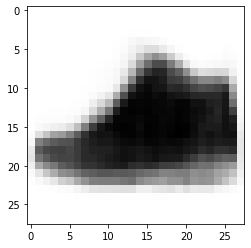

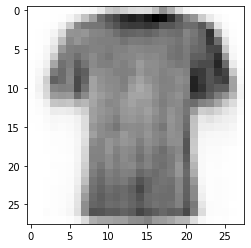

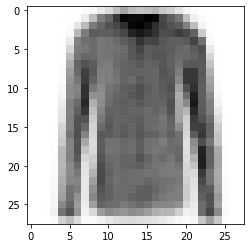

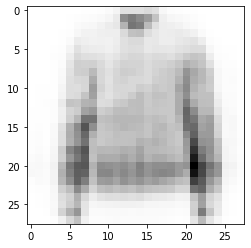

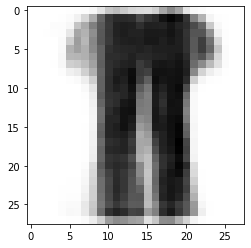

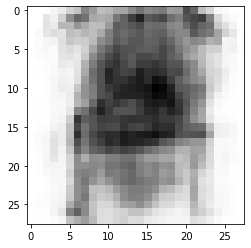

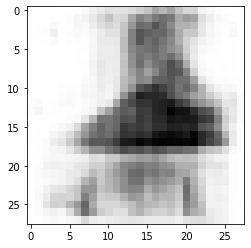

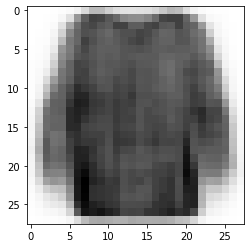

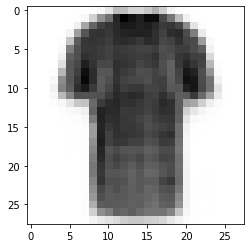

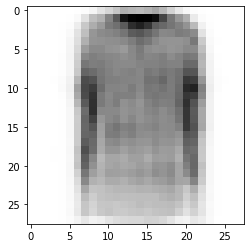

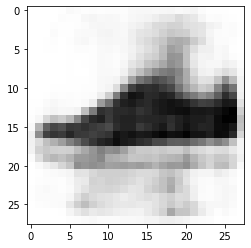

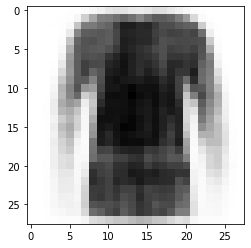

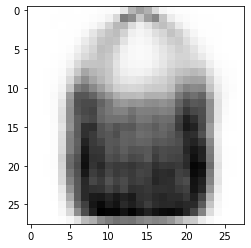

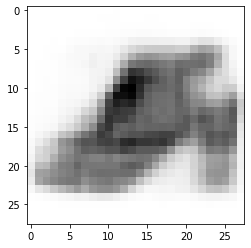

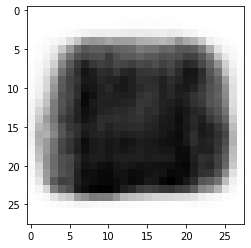

In [391]:
show_samples(m)